In [5]:
! pip install requests

In [6]:
! pip install pandas

In [14]:
import requests
import json
import pandas as pd
import numpy as np

## 結果データを取得する

In [13]:
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        data = json.loads(response.text)
        
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

getResultDataに渡すidはtherb-frontendのUIのここから取得できます
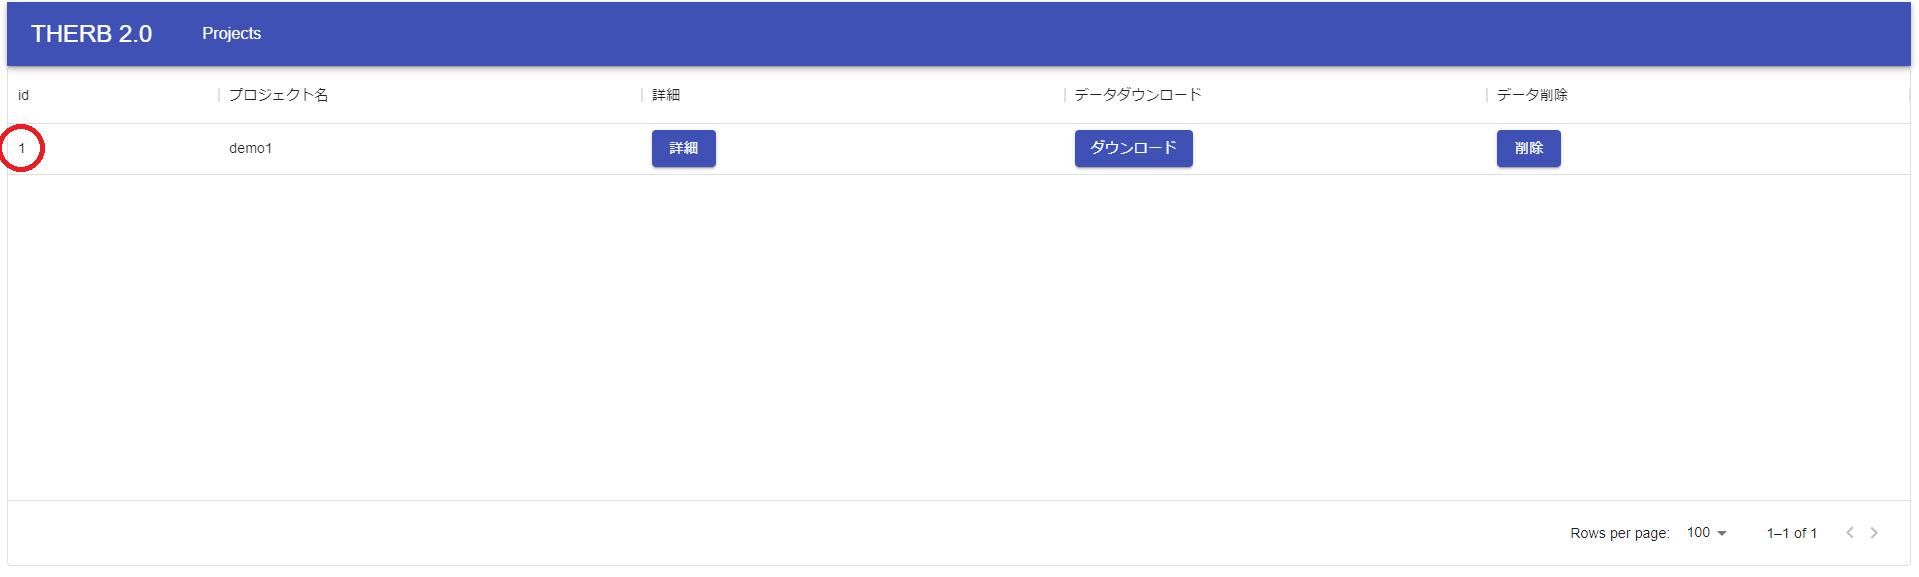

In [15]:
resultData = getResultData(1)

In [16]:
resultData

[{'roomId': 'outdoor',
  'results': {'time': ['01/05/24:00',
    '01/06/01:00',
    '01/06/02:00',
    '01/06/03:00',
    '01/06/04:00',
    '01/06/05:00',
    '01/06/06:00',
    '01/06/07:00',
    '01/06/08:00',
    '01/06/09:00',
    '01/06/10:00',
    '01/06/11:00',
    '01/06/12:00',
    '01/06/13:00',
    '01/06/14:00',
    '01/06/15:00',
    '01/06/16:00',
    '01/06/17:00',
    '01/06/18:00',
    '01/06/19:00',
    '01/06/20:00',
    '01/06/21:00',
    '01/06/22:00',
    '01/06/23:00',
    '01/06/24:00',
    '01/07/01:00',
    '01/07/02:00',
    '01/07/03:00',
    '01/07/04:00',
    '01/07/05:00',
    '01/07/06:00',
    '01/07/07:00',
    '01/07/08:00',
    '01/07/09:00',
    '01/07/10:00',
    '01/07/11:00',
    '01/07/12:00',
    '01/07/13:00',
    '01/07/14:00',
    '01/07/15:00',
    '01/07/16:00',
    '01/07/17:00',
    '01/07/18:00',
    '01/07/19:00',
    '01/07/20:00',
    '01/07/21:00',
    '01/07/22:00',
    '01/07/23:00',
    '01/07/24:00',
    '01/08/01:00',
    '01/

部屋ごとにデータを整理できるようにする必要

In [17]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    
    #transposedRows = np.array(rows,dtype=np.float32).T
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('time')
    df=df.astype('float32')
    #return transposedRows
    return df

In [43]:
df_room1 = convertToDataframe(resultData[0]['results'])
df_room2 = convertToDataframe(resultData[2]['results'])

In [49]:
df_room1["01/06/01:00":"01/12/04:00"]

,temp,relHumidity,absHumidity,sensibleLoad,latentLoad
time,,,,,
01/06/01:00,8.4,67.559998,4.6,4.6,4.6
01/06/02:00,8.3,68.019997,4.6,4.6,4.6
01/06/03:00,8.3,68.019997,4.6,4.6,4.6
01/06/04:00,8.2,68.489998,4.6,4.6,4.6
01/06/05:00,8.2,65.529999,4.4,4.4,4.4
...,...,...,...,...,...
01/11/24:00,9.0,90.000000,6.4,6.4,6.4
01/12/01:00,8.6,93.900002,6.5,6.5,6.5
01/12/02:00,8.6,92.470001,6.4,6.4,6.4


In [45]:
tempArray = np.array(df_room1["temp"])
humidArray = np.array(df_room1["relHumidity"])

In [37]:
tempArray

array([ 9.09,  9.12,  9.15, ..., 13.08, 13.08, 13.07], dtype=float32)

In [42]:
humidArray

array([65.44, 65.32, 65.21, ..., 50.2 , 50.23, 50.26], dtype=float32)

In [46]:
points_array = {'points_series_name': (tempArray, humidArray)}

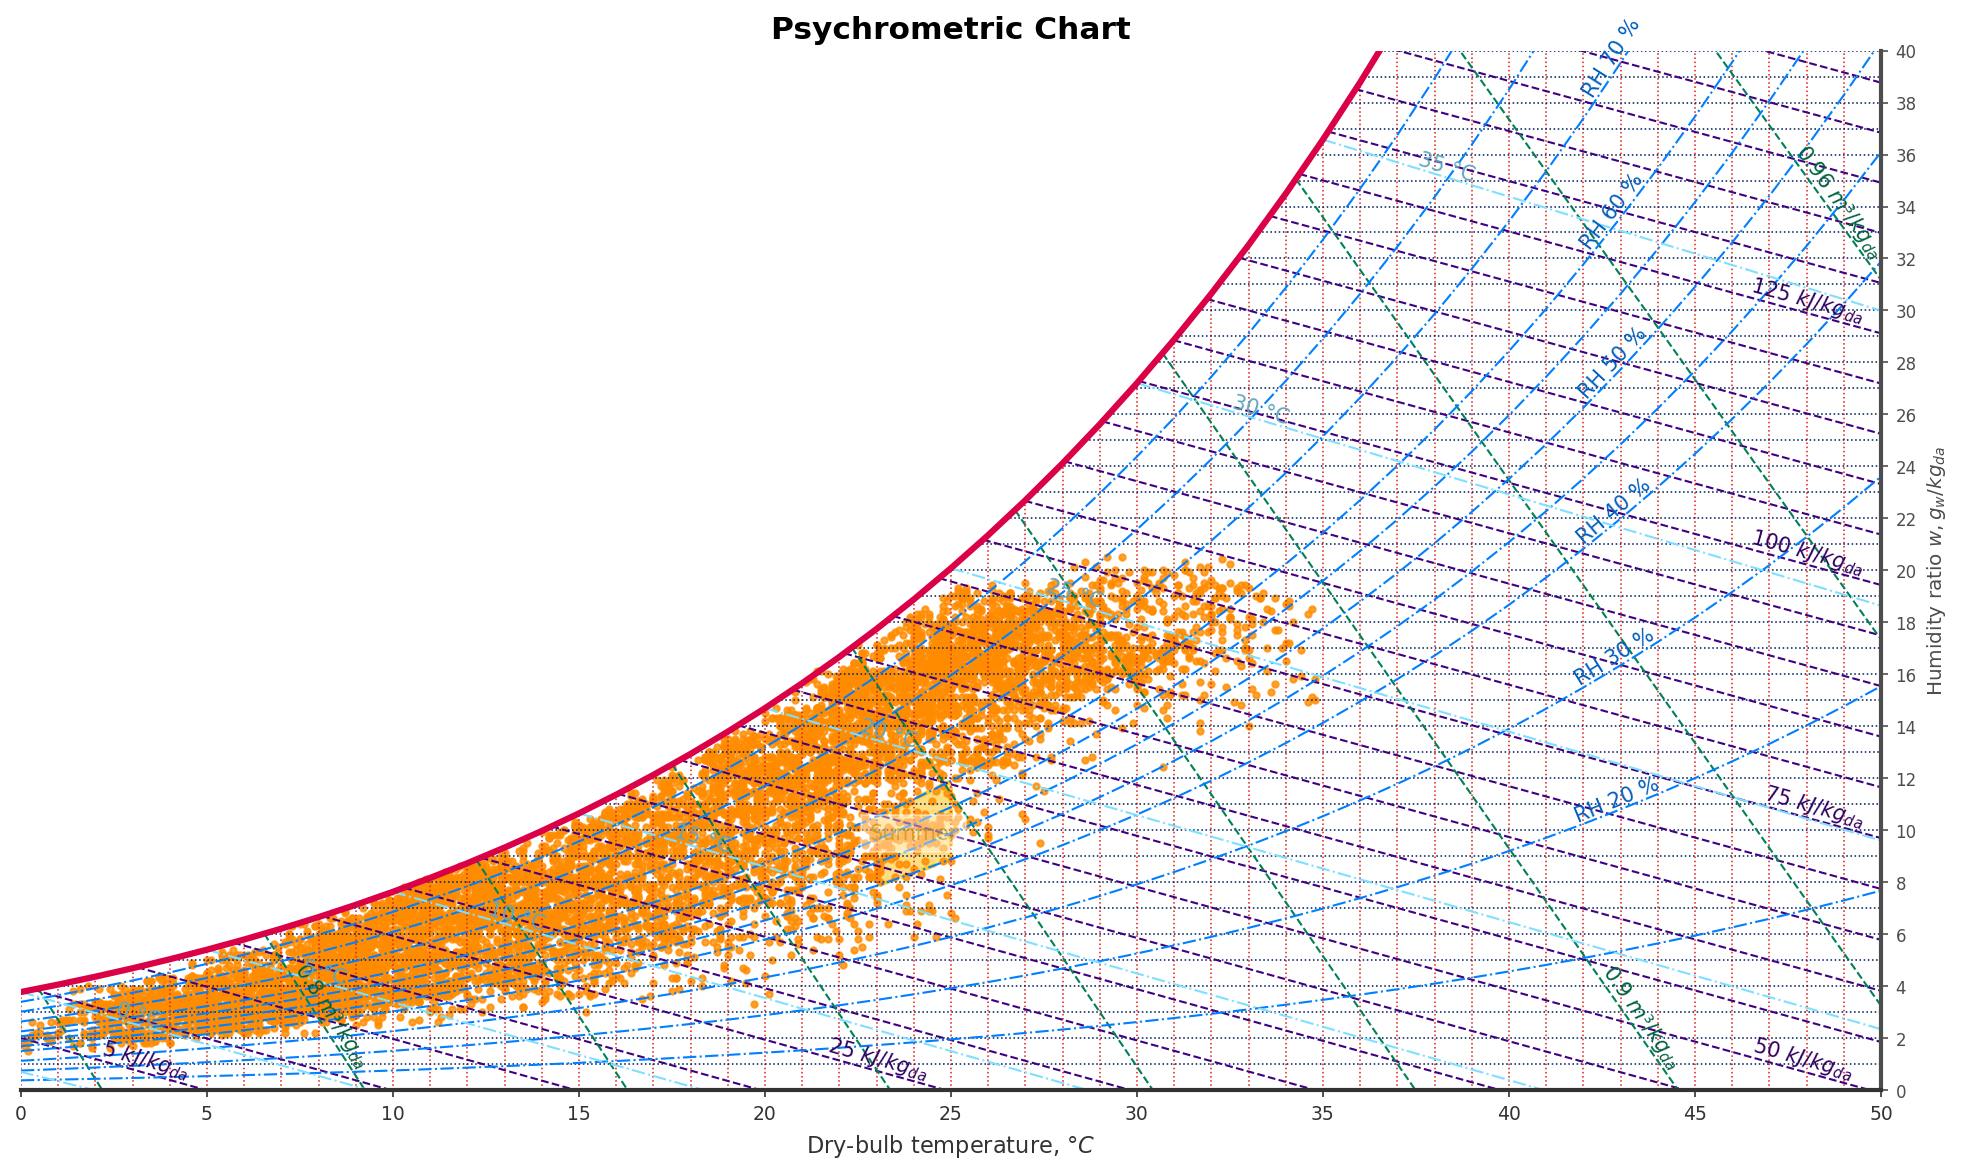

In [47]:
%matplotlib inline
from psychrochart import PsychroChart

from psychrochart import load_config
config_style = load_config('default')
from psychrochart import load_zones
config_zone = load_zones()
config_zone['zones'].pop()
points_style = {'s': 9, 'alpha': 0.8, 'color': 'darkorange'}
chart = PsychroChart(config_style, config_zone)
ax = chart.plot()
chart.plot_points_dbt_rh(points_array, scatter_style=points_style)
ax.get_figure()

## とりあえず折れ線グラフで可視化してみる

In [20]:
! pip install matplotlib seaborn

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

### データをすぐに確認するのはpandasのほうが早い

<AxesSubplot:xlabel='time'>

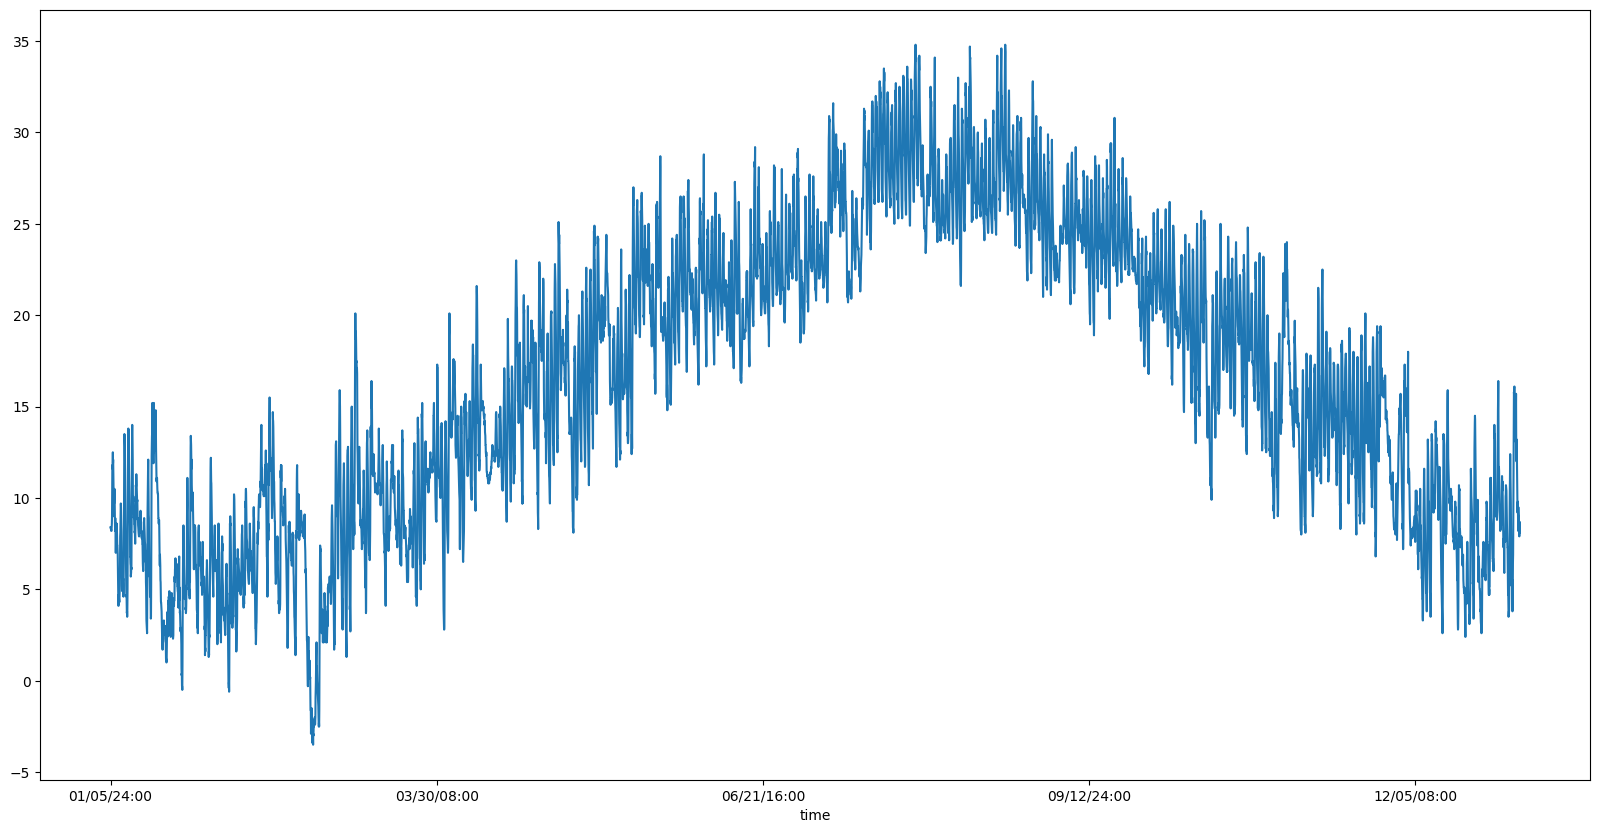

In [23]:
df_room1['temp'].plot.line(figsize=(20,10))

どの温度の時間帯が多いか？

<AxesSubplot:xlabel='time'>

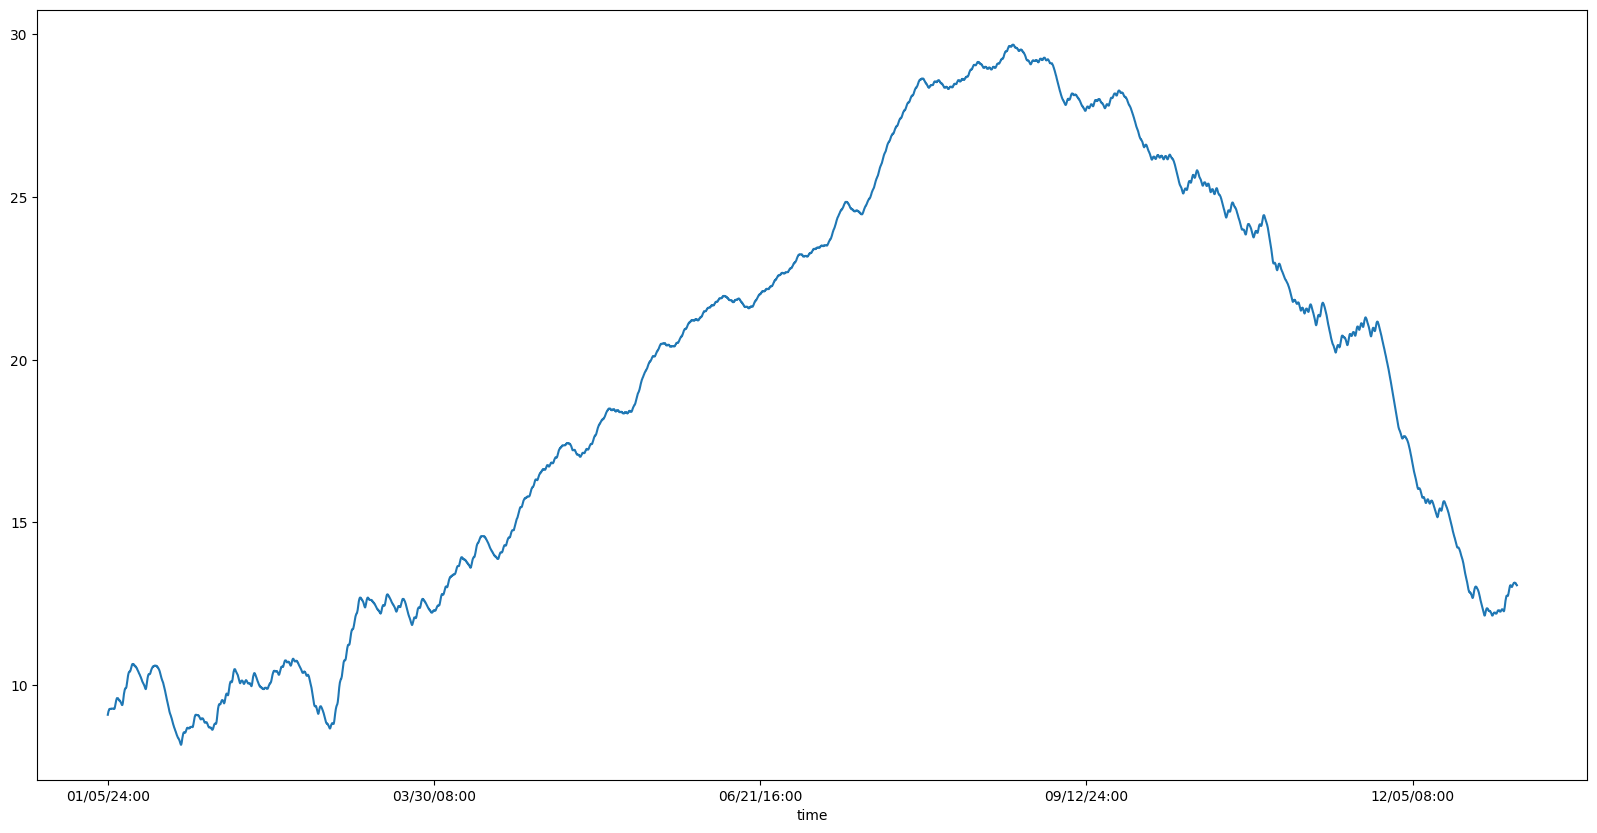

In [24]:
df_room2['temp'].plot.line(figsize=(20,10))

<AxesSubplot:>

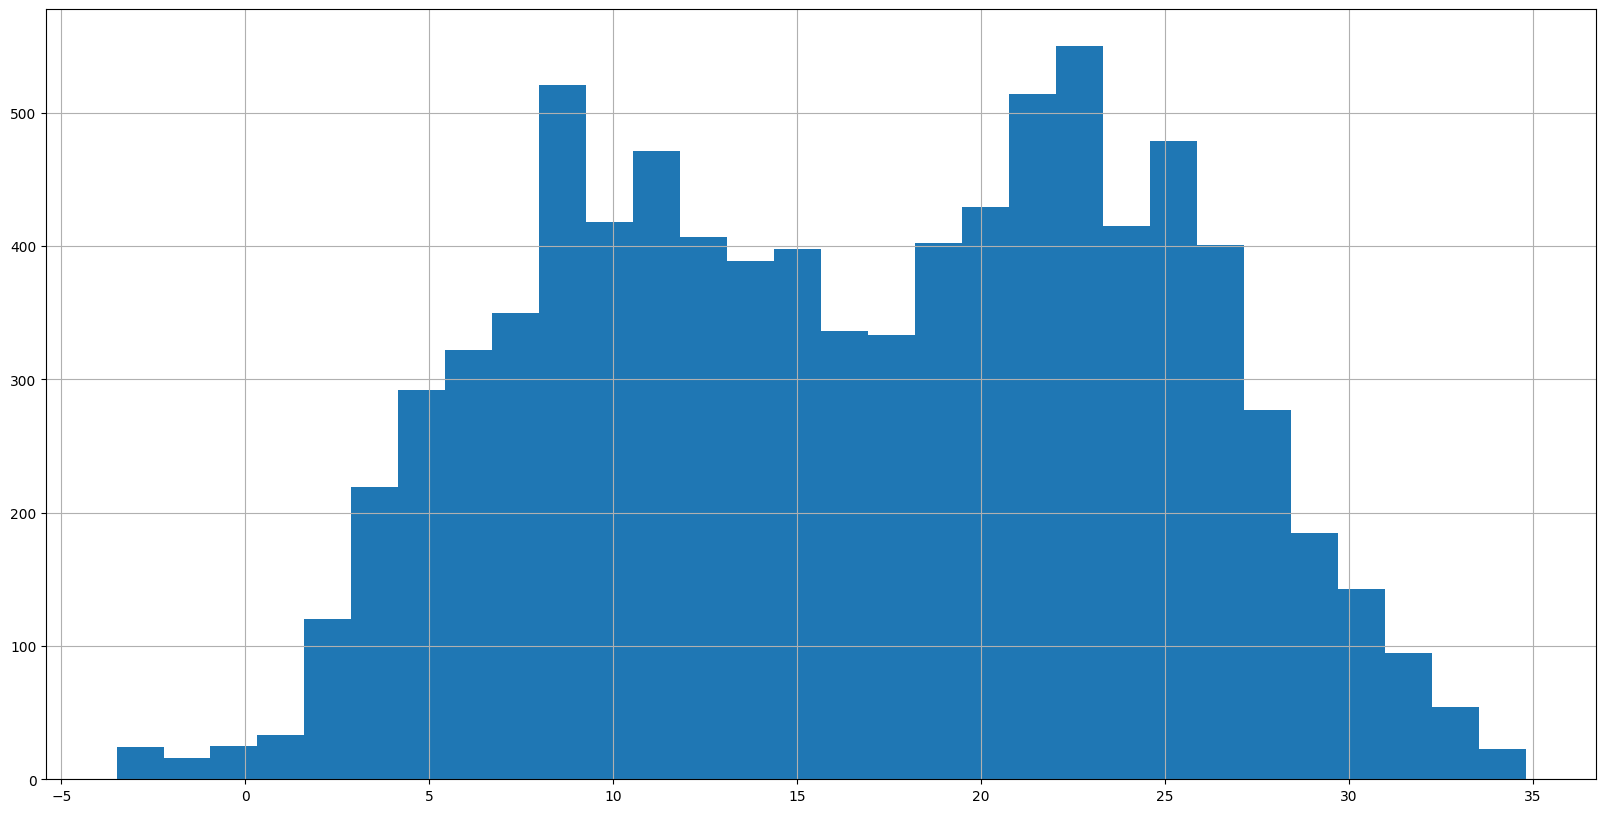

In [25]:
df_room1['temp'].hist(figsize=(20,10),bins=30)

### 快適時間帯の割合は？

In [26]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [27]:
calcPercentage(df_room1['temp'],20,28)

32.1

In [28]:
calcPercentage(df_room2['temp'],20,28)

39.2

In [29]:
calcPercentage(df_room1['temp'],20,28)

32.1

### visualizeの見栄えをよくする

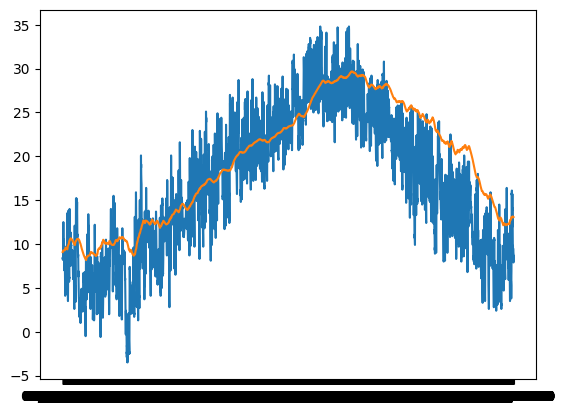

In [30]:
plt.plot(df_room1.index,df_room1['temp'],label = "temp")
plt.plot(df_room2.index,df_room2['temp'],label = "aaa")

#### Seabornは時間がかかりすぎ

<AxesSubplot:xlabel='hour', ylabel='roomT'>

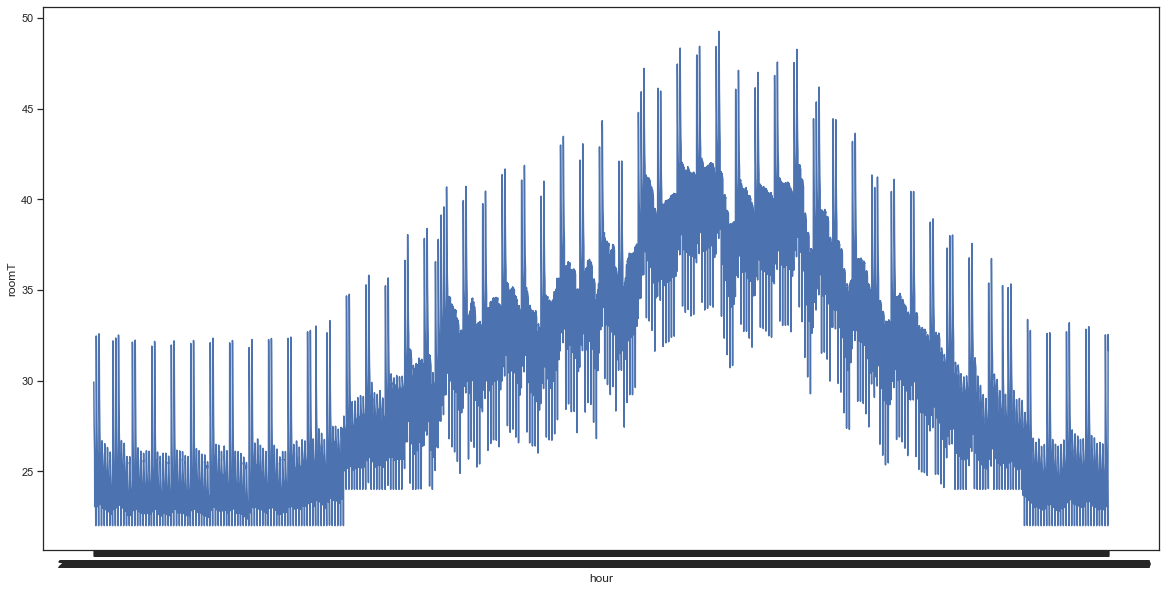

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")

In [6]:
#psychrochartを使ってPythonで湿り空気線図を書く
#https://zenn.dev/kinonotofu/articles/210f2835d9a6e3

! pip install psychrochart

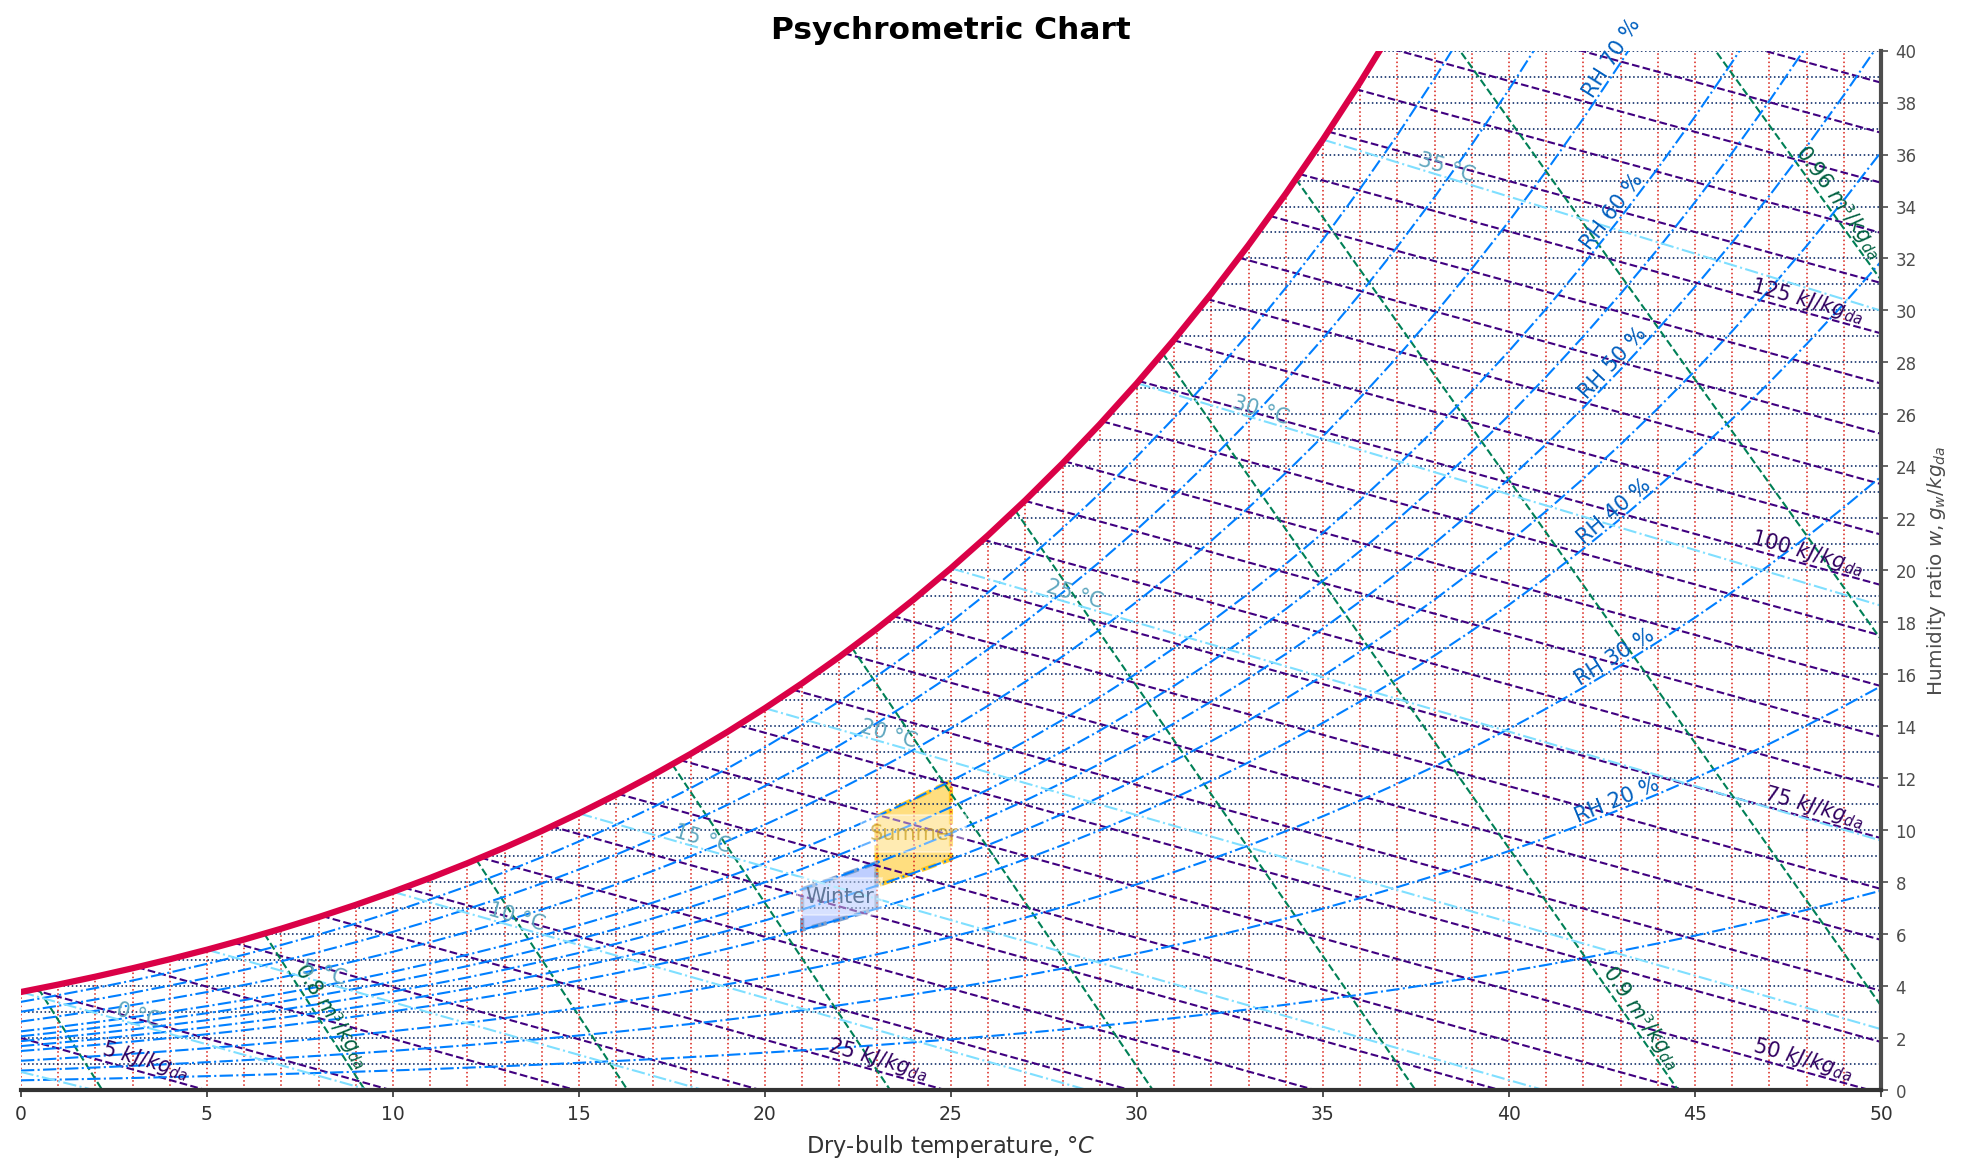

In [31]:
#とりあえずは乗ってあるものをそのままプロット
from psychrochart import PsychroChart

chart_default = PsychroChart('default')
ax = chart_default.plot()
ax.get_figure()

In [4]:
#3. ベースとなる湿り空気線図のスタイルの設定
from psychrochart import load_config
config_style = load_config('default')

#3_1 線と塗りつぶし領域の表示の有無の設定
config_style['chart_params']['with_constant_dry_temp'] = False  # 乾球温度
config_style['chart_params']['with_constant_h'] = False         # 比エンタルピー
config_style['chart_params']['with_constant_humidity'] = False  # 絶対湿度
config_style['chart_params']['with_constant_rh'] = False        # 相対湿度
config_style['chart_params']['with_constant_v'] = True          # 比容積
config_style['chart_params']['with_constant_wet_temp'] = True   # 湿球温度
config_style['chart_params']['with_zones'] = False              # 塗りつぶし領域

chart = PsychroChart(config_style)
ax = chart.plot()
ax.get_figure()

#3.2 線の色と線種と線の太さの設定
#config_styleは、#をとってもうまく起動しない。やり方の摸索が必要
#config_style['constant_dry_temp']['color'] = [0.0, 0.0, 0.0]  # 線の色
#config_style['constant_dry_temp']['linestyle'] = '-'          # 線種
#config_style['constant_dry_temp']['linewidth'] = 0.5          # 線の太さ

#3.3 描画する線と数値の間隔の設定
#Controlキー+ "/"で一気にコメントアウトが出来るよ。
# 全体
# グラフの左右の端を乾球温度の範囲で指定
# config_style['limits']['range_temp_c'] = [0, 50]            
# # グラフの上下の端を絶対湿度の範囲で指定
# config_style['limits']['range_humidity_g_kg'] = [0, 40]     

# # 乾球温度
# # 線の間隔
# config_style['chart_params']['constant_temp_step'] = 1          
# # 数値の間隔
# config_style['chart_params']['constant_temp_label_step'] = 5    

# # 比エンタルピー
# # 線の両端の値
# config_style['chart_params']['range_h'] = [5, 155]                              
# # 線の間隔
# config_style['chart_params']['constant_h_step'] = 5                             
# # 表示する数値
# config_style['chart_params']['constant_h_labels'] = [5, 25, 50, 75, 100, 125]   
# # 数値の位置（0で左寄せ、1で右寄せ）
# config_style['chart_params']['constant_h_labels_loc'] = 1.0                     

# # 絶対湿度
# # 線の間隔
# config_style['chart_params']['constant_humid_step'] = 1                     
# # 数値の間隔
# config_style['chart_params']['constant_humid_label_step'] = 2               
# # 上下端の数値を表示するか
# config_style['chart_params']['constant_humid_label_include_limits'] = True  

# # 相対湿度
# # 線の値
# config_style['chart_params']['constant_rh_curves'] = [10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90]   
# # 表示する数値
# config_style['chart_params']['constant_rh_labels'] = [20, 30, 40, 50, 60, 70, 80] 
# # 数値の位置（0で左寄せ、1で右寄せ）                  
# config_style['chart_params']['constant_rh_labels_loc'] = 0.85                     

# # 比容積
# # 線の両端の値
# config_style['chart_params']['range_vol_m3_kg'] = [0.78, 0.98]          
# # 線の間隔
# config_style['chart_params']['constant_v_step'] = 0.02                  
# # 表示する数値
# config_style['chart_params']['constant_v_labels'] = [0.8, 0.9, 0.96]    
# # 数値の位置（0で左寄せ、1で右寄せ）
# config_style['chart_params']['constant_v_labels_loc'] = 1.0             

# # 湿球温度
# # 線の両端の値
# config_style['chart_params']['range_wet_temp'] = [-10, 40]                   
# # 線の間隔
# config_style['chart_params']['constant_wet_temp_step'] = 5                         
# # 表示する数値
# config_style['chart_params']['constant_wet_temp_labels'] = [0, 5, 10, 15, 20, 25, 30, 35]   
# # 数値の位置（0で左寄せ、1で右寄せ）
# config_style['chart_params']['constant_wet_temp_labels_loc'] = 0.05  

<Figure size 2400x1350 with 1 Axes>

In [31]:
point = {'point1': {'label': 'point1',
                       'style': {'color': [0.85, 0.0, 0.0, 0.5],
                                 'marker': 'o', 
                                 'markersize': 10},
                       'xy': (26, 60)}}

# 描画して設定を確認
chart = PsychroChart(config_style, config_zone)
ax = chart.plot()
chart.plot_points_dbt_rh(point)
ax.get_figure()

NameError: name 'config_zone' is not defined

In [ ]:
#ドッキングってどうするん？